In [2]:
"""  # (Comentário automático) Linha de código executada no fluxo do notebook
[Visão geral do problema]  # (Comentário automático) Linha de código executada no fluxo do notebook
Queremos prever o preço médio de revenda do óleo diesel para a próxima semana.  # (Comentário automático) Linha de código executada no fluxo do notebook
Para facilitar o aprendizado do modelo, transformamos o problema em prever a  # (Comentário automático) Linha de código executada no fluxo do notebook
variação da próxima semana (delta) e não o nível absoluto. Depois somamos esse  # (Comentário automático) Linha de código executada no fluxo do notebook
delta ao preço atual para voltar à escala original. A métrica escolhida é a  # (Comentário automático) Linha de código executada no fluxo do notebook
RMSLE, pois penaliza erros relativos e é adequada para séries de preços  # (Comentário automático) Linha de código executada no fluxo do notebook
positivos com crescimento ao longo do tempo.  # (Comentário automático) Linha de código executada no fluxo do notebook

[Fluxo da solução]  # (Comentário automático) Linha de código executada no fluxo do notebook
1. Carregar e filtrar dados do produto óleo diesel.  # (Comentário automático) Linha de código executada no fluxo do notebook
2. Garantir datas como datetime e checar a consistência das janelas semanais.  # (Comentário automático) Linha de código executada no fluxo do notebook
3. Separar treino e validação por data para simular futuro.  # (Comentário automático) Linha de código executada no fluxo do notebook
4. Construir uma baseline simples usando o valor da semana anterior por estado.  # (Comentário automático) Linha de código executada no fluxo do notebook
5. Engenhar o target como “diferença da próxima semana” e criar features sazonais, lags, diferenças e média móvel.  # (Comentário automático) Linha de código executada no fluxo do notebook
6. Treinar Random Forest para prever o delta da próxima semana.  # (Comentário automático) Linha de código executada no fluxo do notebook
7. Voltar à escala de preço somando o delta previsto ao preço atual.  # (Comentário automático) Linha de código executada no fluxo do notebook
8. Avaliar com RMSLE e comparar com a baseline.  # (Comentário automático) Linha de código executada no fluxo do notebook
9. Rodar um “scan” univariado para ver quais variáveis isoladas ajudam mais.  # (Comentário automático) Linha de código executada no fluxo do notebook
"""  # (Comentário automático) Linha de código executada no fluxo do notebook


'  # (Comentário automático) Linha de código executada no fluxo do notebook\n[Visão geral do problema]  # (Comentário automático) Linha de código executada no fluxo do notebook\nQueremos prever o preço médio de revenda do óleo diesel para a próxima semana.  # (Comentário automático) Linha de código executada no fluxo do notebook\nPara facilitar o aprendizado do modelo, transformamos o problema em prever a  # (Comentário automático) Linha de código executada no fluxo do notebook\nvariação da próxima semana (delta) e não o nível absoluto. Depois somamos esse  # (Comentário automático) Linha de código executada no fluxo do notebook\ndelta ao preço atual para voltar à escala original. A métrica escolhida é a  # (Comentário automático) Linha de código executada no fluxo do notebook\nRMSLE, pois penaliza erros relativos e é adequada para séries de preços  # (Comentário automático) Linha de código executada no fluxo do notebook\npositivos com crescimento ao longo do tempo.  # (Comentário auto

In [2]:
import pandas as pd    # Importa a biblioteca pandas para manipulação de dados tabulares
from sklearn.ensemble import RandomForestRegressor    # Importa o modelo de regressão Random Forest do scikit-learn
from sklearn.metrics import mean_squared_log_error    # Importa a métrica RMSLE (Root Mean Squared Log Error)
import numpy as np    # Importa a biblioteca NumPy para cálculos numéricos e arrays


In [4]:
# RMSLE -> root mean squared log error

In [3]:
pd.read_csv("../database/2004_2021.tsv")  # Lê arquivo CSV/TSV em um DataFrame pandas


,DATA INICIAL\tDATA FINAL\tREGIÃO\tESTADO\tPRODUTO\tNÚMERO DE POSTOS PESQUISADOS\tUNIDADE DE MEDIDA\tPREÇO MÉDIO REVENDA\tDESVIO PADRÃO REVENDA\tPREÇO MÍNIMO REVENDA\tPREÇO MÁXIMO REVENDA\tMARGEM MÉDIA REVENDA\tCOEF DE VARIAÇÃO REVENDA\tPREÇO MÉDIO DISTRIBUIÇÃO\tDESVIO PADRÃO DISTRIBUIÇÃO\tPREÇO MÍNIMO DISTRIBUIÇÃO\tPREÇO MÁXIMO DISTRIBUIÇÃO\tCOEF DE VARIAÇÃO DISTRIBUIÇÃO
0,2004-05-09\t2004-05-15\tCENTRO OESTE\tDISTRITO...
1,2004-05-09\t2004-05-15\tCENTRO OESTE\tGOIAS\tE...
2,2004-05-09\t2004-05-15\tCENTRO OESTE\tMATO GRO...
3,2004-05-09\t2004-05-15\tCENTRO OESTE\tMATO GRO...
4,2004-05-09\t2004-05-15\tNORDESTE\tALAGOAS\tETA...
...,...
120818,2021-04-25\t2021-05-01\tNORTE\tRORAIMA\tOLEO D...
120819,2021-04-25\t2021-05-01\tSUL\tSANTA CATARINA\tO...
120820,2021-04-25\t2021-05-01\tSUDESTE\tSAO PAULO\tOL...
120821,2021-04-25\t2021-05-01\tNORDESTE\tSERGIPE\tOLE...


In [10]:
df = pd.read_csv("../database/2004_2021.tsv", sep="\t")  # Lê arquivo CSV/TSV em um DataFrame pandas com o parâmetro de separador especificado
df.head()  # Exibe as primeiras linhas do DataFrame


,DATA INICIAL,DATA FINAL,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
0,2004-05-09,2004-05-15,CENTRO OESTE,DISTRITO FEDERAL,ETANOL HIDRATADO,127,R$/l,1.288,0.016,1.19,1.350,0.463,0.012,0.825,0.11,0.4201,0.9666,0.133
1,2004-05-09,2004-05-15,CENTRO OESTE,GOIAS,ETANOL HIDRATADO,387,R$/l,1.162,0.114,0.89,1.449,0.399,0.098,0.763,0.088,0.5013,1.05,0.115
2,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO,ETANOL HIDRATADO,192,R$/l,1.389,0.097,1.18,1.760,0.419,0.070,0.97,0.095,0.5614,1.161,0.098
3,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO DO SUL,ETANOL HIDRATADO,162,R$/l,1.262,0.070,1.09,1.509,0.432,0.055,0.83,0.119,0.5991,1.22242,0.143
4,2004-05-09,2004-05-15,NORDESTE,ALAGOAS,ETANOL HIDRATADO,103,R$/l,1.181,0.078,1.05,1.400,0.24,0.066,0.941,0.077,0.7441,1.0317,0.082


In [11]:
df["PRODUTO"].value_counts()  # Conta a frequência de cada categoria/valor na coluna "PRODUTO"

PRODUTO
GASOLINA COMUM        23570
GLP                   23561
ETANOL HIDRATADO      23440
ÓLEO DIESEL           21194
GNV                   14469
ÓLEO DIESEL S10        9113
OLEO DIESEL S10        2376
OLEO DIESEL            2351
GASOLINA ADITIVADA      749
Name: count, dtype: int64

In [12]:
df["PRODUTO"] == "ÓLEO DIESEL"  # (Comentário automático) Linha de código executada no fluxo do notebook # Cria uma série booleana indicando onde a coluna "PRODUTO" é igual a "ÓLEO DIESEL"


0         False
1         False
2         False
3         False
4         False
          ...  
120818    False
120819    False
120820    False
120821    False
120822    False
Name: PRODUTO, Length: 120823, dtype: bool

In [13]:
df[ df["PRODUTO"] == "ÓLEO DIESEL" ]  # (Comentário automático) Linha de código executada no fluxo do notebook # Filtra o DataFrame para incluir apenas as linhas onde a coluna "PRODUTO" é "ÓLEO DIESEL"


,DATA INICIAL,DATA FINAL,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
43547,2004-05-09,2004-05-15,CENTRO OESTE,DISTRITO FEDERAL,ÓLEO DIESEL,125,R$/l,1.447,0.031,1.350,1.490,0.198,0.021,1.249,0.012,1.2153,1.2817,0.01
43548,2004-05-09,2004-05-15,CENTRO OESTE,GOIAS,ÓLEO DIESEL,373,R$/l,1.437,0.059,1.300,1.660,0.157,0.041,1.28,0.024,1.2119,1.3801,0.019
43549,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO,ÓLEO DIESEL,190,R$/l,1.600,0.061,1.460,1.790,0.195,0.038,1.405,0.06,1.22,1.549,0.043
43550,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO DO SUL,ÓLEO DIESEL,157,R$/l,1.526,0.045,1.399,1.659,0.163,0.029,1.363,0.022,1.3055,1.4407,0.016
43551,2004-05-09,2004-05-15,NORDESTE,ALAGOAS,ÓLEO DIESEL,105,R$/l,1.362,0.025,1.310,1.450,0.146,0.018,1.216,0.02,1.1768,1.272,0.016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106722,2019-06-23,2019-06-29,NORTE,RORAIMA,ÓLEO DIESEL,7,R$/l,3.606,0.156,3.400,3.900,0.38,0.043,3.226,0.118,3.1126,3.4,0.037
106723,2019-06-23,2019-06-29,SUL,SANTA CATARINA,ÓLEO DIESEL,96,R$/l,3.504,0.125,3.199,3.799,0.481,0.036,3.023,0.092,2.8989,3.2038,0.03
106724,2019-06-23,2019-06-29,SUDESTE,SAO PAULO,ÓLEO DIESEL,863,R$/l,3.448,0.156,3.099,4.220,0.401,0.045,3.047,0.097,2.8599,3.3481,0.032
106725,2019-06-23,2019-06-29,NORDESTE,SERGIPE,ÓLEO DIESEL,20,R$/l,3.620,0.107,3.470,3.820,0.313,0.030,3.307,0.046,3.2311,3.356,0.014


In [14]:
diesel = df[ df["PRODUTO"] == "ÓLEO DIESEL" ].copy()  # (Comentário automático) Linha de código executada no fluxo do notebook
diesel.head()  # Exibe as primeiras linhas do DataFrame


,DATA INICIAL,DATA FINAL,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
43547,2004-05-09,2004-05-15,CENTRO OESTE,DISTRITO FEDERAL,ÓLEO DIESEL,125,R$/l,1.447,0.031,1.350,1.490,0.198,0.021,1.249,0.012,1.2153,1.2817,0.01
43548,2004-05-09,2004-05-15,CENTRO OESTE,GOIAS,ÓLEO DIESEL,373,R$/l,1.437,0.059,1.300,1.660,0.157,0.041,1.28,0.024,1.2119,1.3801,0.019
43549,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO,ÓLEO DIESEL,190,R$/l,1.600,0.061,1.460,1.790,0.195,0.038,1.405,0.06,1.22,1.549,0.043
43550,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO DO SUL,ÓLEO DIESEL,157,R$/l,1.526,0.045,1.399,1.659,0.163,0.029,1.363,0.022,1.3055,1.4407,0.016
43551,2004-05-09,2004-05-15,NORDESTE,ALAGOAS,ÓLEO DIESEL,105,R$/l,1.362,0.025,1.310,1.450,0.146,0.018,1.216,0.02,1.1768,1.272,0.016


In [15]:
# NaN -> Not a Number

In [16]:
diesel.info()  # Mostra informações gerais do DataFrame (colunas, tipos, nulos)

<class 'pandas.core.frame.DataFrame'>
Index: 21194 entries, 43547 to 106726
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATA INICIAL                   21194 non-null  object 
 1   DATA FINAL                     21194 non-null  object 
 2   REGIÃO                         21194 non-null  object 
 3   ESTADO                         21194 non-null  object 
 4   PRODUTO                        21194 non-null  object 
 5   NÚMERO DE POSTOS PESQUISADOS   21194 non-null  int64  
 6   UNIDADE DE MEDIDA              21194 non-null  object 
 7   PREÇO MÉDIO REVENDA            21194 non-null  float64
 8   DESVIO PADRÃO REVENDA          21194 non-null  float64
 9   PREÇO MÍNIMO REVENDA           21194 non-null  float64
 10  PREÇO MÁXIMO REVENDA           21194 non-null  float64
 11  MARGEM MÉDIA REVENDA           21194 non-null  object 
 12  COEF DE VARIAÇÃO REVENDA       21194 non-null 

In [18]:
diesel.dtypes  # (Comentário automático) Linha de código executada no fluxo do notebook

DATA INICIAL                      object
DATA FINAL                        object
REGIÃO                            object
ESTADO                            object
PRODUTO                           object
NÚMERO DE POSTOS PESQUISADOS       int64
UNIDADE DE MEDIDA                 object
PREÇO MÉDIO REVENDA              float64
DESVIO PADRÃO REVENDA            float64
PREÇO MÍNIMO REVENDA             float64
PREÇO MÁXIMO REVENDA             float64
MARGEM MÉDIA REVENDA              object
COEF DE VARIAÇÃO REVENDA         float64
PREÇO MÉDIO DISTRIBUIÇÃO          object
DESVIO PADRÃO DISTRIBUIÇÃO        object
PREÇO MÍNIMO DISTRIBUIÇÃO         object
PREÇO MÁXIMO DISTRIBUIÇÃO         object
COEF DE VARIAÇÃO DISTRIBUIÇÃO     object
dtype: object

In [19]:
diesel["DATA INICIAL"] = pd.to_datetime(diesel["DATA INICIAL"])  # Converte o tipo de dados (ex.: para datetime, inteiro, float)


In [20]:
diesel["DATA FINAL"] = pd.to_datetime(diesel["DATA FINAL"])  # Converte o tipo de dados (ex.: para datetime, inteiro, float)


In [21]:
diesel.dtypes  # (Comentário automático) Linha de código executada no fluxo do notebook


DATA INICIAL                     datetime64[ns]
DATA FINAL                       datetime64[ns]
REGIÃO                                   object
ESTADO                                   object
PRODUTO                                  object
NÚMERO DE POSTOS PESQUISADOS              int64
UNIDADE DE MEDIDA                        object
PREÇO MÉDIO REVENDA                     float64
DESVIO PADRÃO REVENDA                   float64
PREÇO MÍNIMO REVENDA                    float64
PREÇO MÁXIMO REVENDA                    float64
MARGEM MÉDIA REVENDA                     object
COEF DE VARIAÇÃO REVENDA                float64
PREÇO MÉDIO DISTRIBUIÇÃO                 object
DESVIO PADRÃO DISTRIBUIÇÃO               object
PREÇO MÍNIMO DISTRIBUIÇÃO                object
PREÇO MÁXIMO DISTRIBUIÇÃO                object
COEF DE VARIAÇÃO DISTRIBUIÇÃO            object
dtype: object

In [22]:
diesel["DATA FINAL"] - diesel["DATA INICIAL"]  # (Comentário automático) Linha de código executada no fluxo do notebook


43547    6 days
43548    6 days
43549    6 days
43550    6 days
43551    6 days
          ...  
106722   6 days
106723   6 days
106724   6 days
106725   6 days
106726   6 days
Length: 21194, dtype: timedelta64[ns]

In [23]:
(diesel["DATA FINAL"] - diesel["DATA INICIAL"]).value_counts()  # Conta a frequência de cada categoria/valor


6 days    21194
Name: count, dtype: int64

In [24]:
diesel["DATA FINAL"]  # (Comentário automático) Linha de código executada no fluxo do notebook


43547    2004-05-15
43548    2004-05-15
43549    2004-05-15
43550    2004-05-15
43551    2004-05-15
            ...    
106722   2019-06-29
106723   2019-06-29
106724   2019-06-29
106725   2019-06-29
106726   2019-06-29
Name: DATA FINAL, Length: 21194, dtype: datetime64[ns]

In [25]:
diesel_treino = diesel[diesel["DATA FINAL"] < "2019-01-01"].copy()  # (Comentário automático) Linha de código executada no fluxo do notebook


In [29]:
diesel_valid = diesel[ diesel["DATA FINAL"] >= "2019-01-01" ].copy()  # (Comentário automático) Linha de código executada no fluxo do notebook


### BASELINE

In [30]:
y_treino = diesel_treino["PREÇO MÉDIO REVENDA"]  # (Comentário automático) Linha de código executada no fluxo do notebook


In [31]:
y_valid = diesel_valid["PREÇO MÉDIO REVENDA"]  # (Comentário automático) Linha de código executada no fluxo do notebook


In [32]:
diesel_treino.head()  # Exibe as primeiras linhas do DataFrame


,DATA INICIAL,DATA FINAL,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
43547,2004-05-09,2004-05-15,CENTRO OESTE,DISTRITO FEDERAL,ÓLEO DIESEL,125,R$/l,1.447,0.031,1.350,1.490,0.198,0.021,1.249,0.012,1.2153,1.2817,0.01
43548,2004-05-09,2004-05-15,CENTRO OESTE,GOIAS,ÓLEO DIESEL,373,R$/l,1.437,0.059,1.300,1.660,0.157,0.041,1.28,0.024,1.2119,1.3801,0.019
43549,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO,ÓLEO DIESEL,190,R$/l,1.600,0.061,1.460,1.790,0.195,0.038,1.405,0.06,1.22,1.549,0.043
43550,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO DO SUL,ÓLEO DIESEL,157,R$/l,1.526,0.045,1.399,1.659,0.163,0.029,1.363,0.022,1.3055,1.4407,0.016
43551,2004-05-09,2004-05-15,NORDESTE,ALAGOAS,ÓLEO DIESEL,105,R$/l,1.362,0.025,1.310,1.450,0.146,0.018,1.216,0.02,1.1768,1.272,0.016


In [33]:
diesel_treino.groupby(["ESTADO"])["PREÇO MÉDIO REVENDA"].shift(1)  # Agrupa dados por uma ou mais colunas para agregações


43547       NaN
43548       NaN
43549       NaN
43550       NaN
43551       NaN
          ...  
102818    3.559
102819    3.368
102820    3.308
102821    3.516
102822    3.510
Name: PREÇO MÉDIO REVENDA, Length: 20492, dtype: float64

In [34]:
diesel_valid.groupby(["ESTADO"])["PREÇO MÉDIO REVENDA"].shift(1)  # Agrupa dados por uma ou mais colunas para agregações


102947      NaN
102948      NaN
102949      NaN
102950      NaN
102951      NaN
          ...  
106722    3.625
106723    3.524
106724    3.474
106725    3.621
106726    3.609
Name: PREÇO MÉDIO REVENDA, Length: 702, dtype: float64

In [35]:
baseline_treino = diesel_treino.groupby(["ESTADO"])["PREÇO MÉDIO REVENDA"].shift(1)  # Agrupa dados por uma ou mais colunas para agregações


In [36]:
baseline_valid = diesel_valid.groupby(["ESTADO"])["PREÇO MÉDIO REVENDA"].shift(1)  # Agrupa dados por uma ou mais colunas para agregações


In [37]:
diesel_treino[diesel_treino["ESTADO"] == "SAO PAULO"].head()  # Exibe as primeiras linhas do DataFrame


,DATA INICIAL,DATA FINAL,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
43570,2004-05-09,2004-05-15,SUDESTE,SAO PAULO,ÓLEO DIESEL,3196,R$/l,1.368,0.057,1.210,1.590,0.158,0.042,1.21,0.026,1.141,1.369,0.021
43597,2004-05-16,2004-05-22,SUDESTE,SAO PAULO,ÓLEO DIESEL,3201,R$/l,1.368,0.057,1.239,1.599,0.158,0.042,1.21,0.026,1.125,1.369,0.021
43624,2004-05-23,2004-05-29,SUDESTE,SAO PAULO,ÓLEO DIESEL,3216,R$/l,1.368,0.057,1.220,1.590,0.159,0.042,1.209,0.025,1.125,1.369,0.021
43651,2004-05-30,2004-06-05,SUDESTE,SAO PAULO,ÓLEO DIESEL,3200,R$/l,1.368,0.057,1.220,1.669,0.159,0.042,1.209,0.025,1.125,1.369,0.021
43678,2004-06-06,2004-06-12,SUDESTE,SAO PAULO,ÓLEO DIESEL,3222,R$/l,1.369,0.056,1.220,1.590,0.159,0.041,1.21,0.025,1.125,1.369,0.021


In [38]:
#RMSLE - root mean squared log error
np.sqrt(   # (Comentário automático) Linha de código executada no fluxo do notebook
        mean_squared_log_error( y_valid[baseline_valid.notnull()],  # Calcula a métrica RMSLE entre valores reais e previstos
                               baseline_valid[baseline_valid.notnull()] )  # (Comentário automático) Linha de código executada no fluxo do notebook
        )  # (Comentário automático) Linha de código executada no fluxo do notebook


np.float64(0.00725323000861358)

In [39]:
#Resultado da Basline atual
0.00725323000861358 * 100  # (Comentário automático) Linha de código executada no fluxo do notebook


0.7253230008613579

### Machine Learning

In [40]:
diesel_treino.head()  # Exibe as primeiras linhas do DataFrame


,DATA INICIAL,DATA FINAL,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
43547,2004-05-09,2004-05-15,CENTRO OESTE,DISTRITO FEDERAL,ÓLEO DIESEL,125,R$/l,1.447,0.031,1.350,1.490,0.198,0.021,1.249,0.012,1.2153,1.2817,0.01
43548,2004-05-09,2004-05-15,CENTRO OESTE,GOIAS,ÓLEO DIESEL,373,R$/l,1.437,0.059,1.300,1.660,0.157,0.041,1.28,0.024,1.2119,1.3801,0.019
43549,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO,ÓLEO DIESEL,190,R$/l,1.600,0.061,1.460,1.790,0.195,0.038,1.405,0.06,1.22,1.549,0.043
43550,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO DO SUL,ÓLEO DIESEL,157,R$/l,1.526,0.045,1.399,1.659,0.163,0.029,1.363,0.022,1.3055,1.4407,0.016
43551,2004-05-09,2004-05-15,NORDESTE,ALAGOAS,ÓLEO DIESEL,105,R$/l,1.362,0.025,1.310,1.450,0.146,0.018,1.216,0.02,1.1768,1.272,0.016


In [41]:
df_x_treino = pd.DataFrame(index=diesel_treino.index)  # (Comentário automático) Linha de código executada no fluxo do notebook
df_x_valid = pd.DataFrame(index=diesel_valid.index)  # (Comentário automático) Linha de código executada no fluxo do notebook


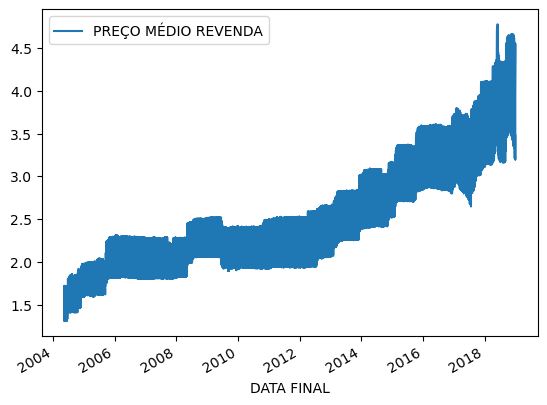

In [42]:
diesel_treino.plot(x="DATA FINAL", y="PREÇO MÉDIO REVENDA");  # Gera visualizações gráficas dos dados/resultados


In [43]:
def target_diff(x):  # Define uma função reutilizável
  return x.diff().shift(-1)  # Desloca valores para criar lags (defasagens)


In [44]:
diesel_treino["DIFF PREÇO MÉDIO REVENDA"] = diesel_treino.groupby(["ESTADO"])["PREÇO MÉDIO REVENDA"].apply(target_diff).reset_index(level=0,drop=True)  # Agrupa dados por uma ou mais colunas para agregações
diesel_treino["DIFF PREÇO MÉDIO REVENDA"]  # (Comentário automático) Linha de código executada no fluxo do notebook


43547     0.013
43548     0.001
43549    -0.003
43550    -0.002
43551    -0.003
          ...  
102818      NaN
102819      NaN
102820      NaN
102821      NaN
102822      NaN
Name: DIFF PREÇO MÉDIO REVENDA, Length: 20492, dtype: float64

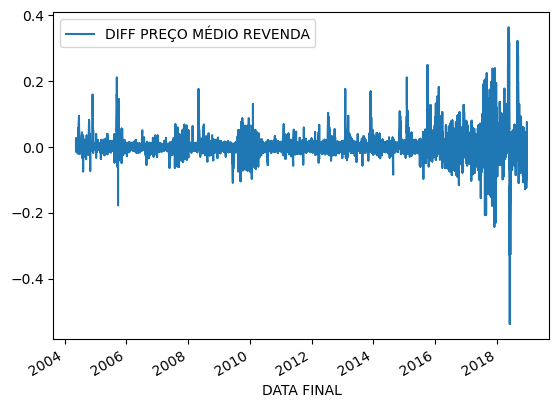

In [45]:
diesel_treino.plot(x="DATA FINAL", y="DIFF PREÇO MÉDIO REVENDA");  # Gera visualizações gráficas dos dados/resultados


In [46]:
df_x_treino["DIFF_PREÇO_MEDIO_REVENDA_PROXIMA_SEMANA"] = diesel_treino.groupby(["ESTADO"])["PREÇO MÉDIO REVENDA"].apply(target_diff).reset_index(level=0,drop=True)  # Agrupa dados por uma ou mais colunas para agregações


In [47]:
df_x_valid["DIFF_PREÇO_MEDIO_REVENDA_PROXIMA_SEMANA"] = diesel_valid.groupby(["ESTADO"])["PREÇO MÉDIO REVENDA"].apply(target_diff).reset_index(level=0,drop=True)  # Agrupa dados por uma ou mais colunas para agregações


#### Sazonal

In [48]:
df_x_treino["MES"] = diesel_treino["DATA FINAL"].dt.month  # (Comentário automático) Linha de código executada no fluxo do notebook
df_x_treino["DIA"] = diesel_treino["DATA FINAL"].dt.day  # (Comentário automático) Linha de código executada no fluxo do notebook
df_x_treino["DIA_DA_SEMANA"] = diesel_treino["DATA FINAL"].dt.weekday  # (Comentário automático) Linha de código executada no fluxo do notebook
df_x_treino["DIA_DO_ANO"] = diesel_treino["DATA FINAL"].dt.dayofyear  # (Comentário automático) Linha de código executada no fluxo do notebook


In [49]:
df_x_valid["MES"] = diesel_valid["DATA FINAL"].dt.month  # (Comentário automático) Linha de código executada no fluxo do notebook
df_x_valid["DIA"] = diesel_valid["DATA FINAL"].dt.day  # (Comentário automático) Linha de código executada no fluxo do notebook
df_x_valid["DIA_DA_SEMANA"] = diesel_valid["DATA FINAL"].dt.weekday  # (Comentário automático) Linha de código executada no fluxo do notebook
df_x_valid["DIA_DO_ANO"] = diesel_valid["DATA FINAL"].dt.dayofyear  # (Comentário automático) Linha de código executada no fluxo do notebook


In [50]:
df_x_treino.head()  # Exibe as primeiras linhas do DataFrame


,DIFF_PREÇO_MEDIO_REVENDA_PROXIMA_SEMANA,MES,DIA,DIA_DA_SEMANA,DIA_DO_ANO
43547,0.013,5,15,5,136
43548,0.001,5,15,5,136
43549,-0.003,5,15,5,136
43550,-0.002,5,15,5,136
43551,-0.003,5,15,5,136


In [51]:
df_x_treino.head()  # Exibe as primeiras linhas do DataFrame


,DIFF_PREÇO_MEDIO_REVENDA_PROXIMA_SEMANA,MES,DIA,DIA_DA_SEMANA,DIA_DO_ANO
43547,0.013,5,15,5,136
43548,0.001,5,15,5,136
43549,-0.003,5,15,5,136
43550,-0.002,5,15,5,136
43551,-0.003,5,15,5,136


## LAG

In [52]:
df_x_treino["PREÇO_MEDIO_REVENDA_ATUAL"] = diesel_treino["PREÇO MÉDIO REVENDA"]  # (Comentário automático) Linha de código executada no fluxo do notebook
df_x_valid["PREÇO_MEDIO_REVENDA_ATUAL"] = diesel_valid["PREÇO MÉDIO REVENDA"]  # (Comentário automático) Linha de código executada no fluxo do notebook


In [53]:
## Diferença do Lag
## diff_lag = yt_1 - yt_2


In [54]:
df_x_treino["DIFF_PREÇO_MEDIO_REVENDA_ATUAL"] = diesel_treino.groupby(["ESTADO"])["PREÇO MÉDIO REVENDA"].diff()  # Agrupa dados por uma ou mais colunas para agregações
df_x_valid["DIFF_PREÇO_MEDIO_REVENDA_ATUAL"] = diesel_valid.groupby(["ESTADO"])["PREÇO MÉDIO REVENDA"].diff()  # Agrupa dados por uma ou mais colunas para agregações


In [55]:
## Media Móvel


In [56]:
roll = diesel_treino.groupby(["ESTADO"])["PREÇO MÉDIO REVENDA"].rolling(4).mean()  # Agrupa dados por uma ou mais colunas para agregações
roll.head()  # Exibe as primeiras linhas do DataFrame


ESTADO       
ACRE    43560       NaN
        43587       NaN
        43614       NaN
        43641    1.7165
        43668    1.7140
Name: PREÇO MÉDIO REVENDA, dtype: float64

In [57]:
roll.reset_index(level=0, drop=True).head()  # Exibe as primeiras linhas do DataFrame


43560       NaN
43587       NaN
43614       NaN
43641    1.7165
43668    1.7140
Name: PREÇO MÉDIO REVENDA, dtype: float64

In [58]:
df_x_treino["MEDIA_MOVEL_PREÇO_MEDIO_REVENDA_4_SEMANAS"] = diesel_treino.groupby(["ESTADO"])["PREÇO MÉDIO REVENDA"].rolling(4).mean().reset_index(level=0,drop=True)  # Agrupa dados por uma ou mais colunas para agregações
df_x_valid["MEDIA_MOVEL_PREÇO_MEDIO_REVENDA_4_SEMANAS"] = diesel_valid.groupby(["ESTADO"])["PREÇO MÉDIO REVENDA"].rolling(4).mean().reset_index(level=0,drop=True)  # Agrupa dados por uma ou mais colunas para agregações


In [59]:
df_x_treino.head()  # Exibe as primeiras linhas do DataFrame


,DIFF_PREÇO_MEDIO_REVENDA_PROXIMA_SEMANA,MES,DIA,DIA_DA_SEMANA,DIA_DO_ANO,PREÇO_MEDIO_REVENDA_ATUAL,DIFF_PREÇO_MEDIO_REVENDA_ATUAL,MEDIA_MOVEL_PREÇO_MEDIO_REVENDA_4_SEMANAS
43547,0.013,5,15,5,136,1.447,NaN,NaN
43548,0.001,5,15,5,136,1.437,NaN,NaN
43549,-0.003,5,15,5,136,1.600,NaN,NaN
43550,-0.002,5,15,5,136,1.526,NaN,NaN
43551,-0.003,5,15,5,136,1.362,NaN,NaN


In [60]:
df_x_treino = df_x_treino.dropna()  # Remove linhas/colunas com valores ausentes
df_x_valid = df_x_valid.dropna()  # Remove linhas/colunas com valores ausentes


In [61]:
Xtr, ytr = df_x_treino.drop(["DIFF_PREÇO_MEDIO_REVENDA_PROXIMA_SEMANA"], axis=1), df_x_treino["DIFF_PREÇO_MEDIO_REVENDA_PROXIMA_SEMANA"]  # Remove colunas/linhas específicas do DataFrame

Xval, yval = df_x_valid.drop(["DIFF_PREÇO_MEDIO_REVENDA_PROXIMA_SEMANA"], axis=1), df_x_valid["DIFF_PREÇO_MEDIO_REVENDA_PROXIMA_SEMANA"]  # Remove colunas/linhas específicas do DataFrame

Xtr.isnull().mean()  # (Comentário automático) Linha de código executada no fluxo do notebook


MES                                          0.0
DIA                                          0.0
DIA_DA_SEMANA                                0.0
DIA_DO_ANO                                   0.0
PREÇO_MEDIO_REVENDA_ATUAL                    0.0
DIFF_PREÇO_MEDIO_REVENDA_ATUAL               0.0
MEDIA_MOVEL_PREÇO_MEDIO_REVENDA_4_SEMANAS    0.0
dtype: float64

In [62]:
mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=200)  # Instancia o modelo Random Forest Regressor com hiperparâmetros

mdl.fit(Xtr, ytr)  # Treina/ajusta o modelo com os dados de entrada e target

p = mdl.predict(Xval)  # Gera previsões a partir do modelo treinado


In [63]:
Xval  # (Comentário automático) Linha de código executada no fluxo do notebook


,MES,DIA,DIA_DA_SEMANA,DIA_DO_ANO,PREÇO_MEDIO_REVENDA_ATUAL,DIFF_PREÇO_MEDIO_REVENDA_ATUAL,MEDIA_MOVEL_PREÇO_MEDIO_REVENDA_4_SEMANAS
103395,1,26,5,26,4.564,-0.003,4.55500
103396,1,26,5,26,3.657,-0.013,3.68775
103397,1,26,5,26,4.004,-0.051,3.98075
103398,1,26,5,26,3.556,-0.026,3.62675
103399,1,26,5,26,3.422,-0.005,3.42825
...,...,...,...,...,...,...,...
106573,6,22,5,173,3.625,-0.001,3.65450
106574,6,22,5,173,3.524,-0.002,3.53675
106575,6,22,5,173,3.474,-0.046,3.51475
106576,6,22,5,173,3.621,-0.061,3.67700


In [64]:
p_final = Xval["PREÇO_MEDIO_REVENDA_ATUAL"] + p  # (Comentário automático) Linha de código executada no fluxo do notebook


In [65]:
yval_final = Xval["PREÇO_MEDIO_REVENDA_ATUAL"] + yval  # (Comentário automático) Linha de código executada no fluxo do notebook


In [66]:
np.sqrt(  # (Comentário automático) Linha de código executada no fluxo do notebook
        mean_squared_log_error(yval_final, p_final)  # Calcula a métrica RMSLE entre valores reais e previstos
        ) * 100  # (Comentário automático) Linha de código executada no fluxo do notebook


np.float64(1.4140595779155885)

In [67]:
baseline = 0.725  # (Comentário automático) Linha de código executada no fluxo do notebook
modelo_ml = 1.41  # (Comentário automático) Linha de código executada no fluxo do notebook


## Sequential Forward Feature Selection

In [68]:
var_menor_erro = None  # (Comentário automático) Linha de código executada no fluxo do notebook
valor_menor_erro = 1000.  # (Comentário automático) Linha de código executada no fluxo do notebook

for var in Xtr.columns:  # Laço de repetição (loop) para iterar sobre uma sequência
  mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)  # Instancia o modelo Random Forest Regressor com hiperparâmetros
  mdl.fit(Xtr[[var]], ytr)  # Treina/ajusta o modelo com os dados de entrada e target
  p = mdl.predict(Xval[[var]])  # Gera previsões a partir do modelo treinado

  p_final = Xval["PREÇO_MEDIO_REVENDA_ATUAL"] + p  # (Comentário automático) Linha de código executada no fluxo do notebook
  yval_final = Xval["PREÇO_MEDIO_REVENDA_ATUAL"] + yval  # (Comentário automático) Linha de código executada no fluxo do notebook

  erro = np.sqrt(mean_squared_log_error(yval_final, p_final)) * 100  # Calcula a métrica RMSLE entre valores reais e previstos

  print("Variável: {} - Erro: {:.4f}\n".format(var,erro))  # (Comentário automático) Linha de código executada no fluxo do notebook

  if erro < valor_menor_erro:  # Condicional: executa o bloco apenas se a condição for verdadeira
    var_menor_erro = var  # (Comentário automático) Linha de código executada no fluxo do notebook
    valor_menor_erro = erro  # (Comentário automático) Linha de código executada no fluxo do notebook

print("Melhor Variável: {} - Erro: {:,.4f}\n".format(var_menor_erro, valor_menor_erro))  # (Comentário automático) Linha de código executada no fluxo do notebook

print("Erro inicial da baseline: ", baseline)  # (Comentário automático) Linha de código executada no fluxo do notebook


Variável: MES - Erro: 0.6968

Variável: DIA - Erro: 0.7318

Variável: DIA_DA_SEMANA - Erro: 0.7141

Variável: DIA_DO_ANO - Erro: 0.7412

Variável: PREÇO_MEDIO_REVENDA_ATUAL - Erro: 1.2999

Variável: DIFF_PREÇO_MEDIO_REVENDA_ATUAL - Erro: 0.7565

Variável: MEDIA_MOVEL_PREÇO_MEDIO_REVENDA_4_SEMANAS - Erro: 1.4937

Melhor Variável: MES - Erro: 0.6968

Erro inicial da baseline:  0.725


### FIM